In [11]:
import pandas as pd
import cv2
import numpy as np
import matplotlib.pyplot as plt
#jupyter内で画像を表示
%matplotlib inline 
#別ウィンドウで画像表示
# %matplotlib qt 
import csv
import json
from ipywidgets import interact, interactive, fixed, RadioButtons
import ipywidgets as widgets
from IPython.display import display
import pathlib
seed = '10000'
node_num = '200'
shadow = 'shadow30_2'
sigo_path = pathlib.Path('../../get_data/geocast/' + shadow + '/gsigo/gsigo-seed_' +seed +'nodenum_' +node_num+'.csv')
lsgo_path = pathlib.Path('../../get_data/geocast/' + shadow + '/glsgo/glsgo-seed_' +seed +'nodenum_' +node_num+'.csv')
# sigo_path = pathlib.Path('../../ns3.30/data/no_buildings/sigo/sigo-seed_' +seed +'nodenum_' +node_num+'.csv')
# lsgo_path = pathlib.Path('../../ns3.30/data/no_buildings/lsgo/lsgo-seed_' +seed +'nodenum_' +node_num+'.csv')

# csvファイルの取得
pandasを利用：https://note.nkmk.me/python-pandas-value-counts/

In [12]:
sigo_df = pd.read_csv(sigo_path)
lsgo_df = pd.read_csv(lsgo_path)

In [13]:
print(sigo_path)
print(lsgo_path)

../../get_data/geocast/shadow30_2/gsigo/gsigo-seed_10000nodenum_200.csv
../../get_data/geocast/shadow30_2/glsgo/glsgo-seed_10000nodenum_200.csv


# source_idごとのパケット数

In [14]:
lsgo_df['source_id'].value_counts().to_dict()

{11: 8,
 23: 54,
 32: 5,
 38: 241,
 60: 20,
 98: 67,
 110: 15,
 116: 16,
 166: 41,
 171: 14}


destination_id を重複なしにリスト保存

In [15]:
sigo_df['source_id'].value_counts().to_dict()

{11: 8,
 23: 54,
 32: 5,
 38: 241,
 60: 20,
 98: 67,
 110: 15,
 116: 16,
 166: 41,
 171: 14}

In [6]:
source_list =lsgo_df['source_id'].value_counts().index.tolist()
source_list.sort()
len(source_list)

10

In [7]:
source_list = sigo_df['source_id'].value_counts().index.tolist()
source_list.sort()
len(source_list)

10

sigoとlsgoそれぞれ目的地に届いたidだけをlistに保存

# 軌跡描画

In [8]:
def draw_source_area(log, img_area):
    MR = 150 #中心座標とmulticast regionの距離
    #multicast region 中心座標描画
    cv2.circle(img=img_area, center=(log.destination_x,
                           log.destination_y), radius=15, color=(255,0,255), thickness=-1)
    cv2.rectangle(img_area, (log.destination_x - MR, log.destination_y - MR), (log.destination_x + MR, log.destination_y + MR), (255, 255, 0),thickness=8)
    #source nodeを視覚で囲む
    cv2.rectangle(img_area, (log.send_x - 15, log.send_y - 15), (log.send_x + 15, log.send_y + 15), (255, 255, 0),thickness=8)
    #方眼
    plt.figure(figsize=(10, 10))
    print('グラフサイズ')
    plt.grid(color='w', linestyle='dotted', linewidth=1.0)
    plt.xlim([0, 1000])
    plt.xticks([1000,800,600,400,200, 0]) 
    plt.ylim([0, 1000])
    plt.yticks([1000,800,600,400,200, 0])  #メモリの間隔を指定 
    print('source_area 描画')

# パケットの軌跡を描画
def draw(log,count,img_area,protocol,text):
    flooding_color = (0, 128, 0)
    if protocol == 'sigo':
        line_color = (0, 255, 0)
        thick = 7
        des_thick = 8
    else:
        line_color = (255, 0, 0)
        thick = 2
        des_thick = 2
    
    if log.recv_priority == 10000000:
        cv2.arrowedLine(img_area,(log.send_x, log.send_y), 
                            (log.recv_x, log.recv_y), flooding_color, thickness=thick, tipLength=0.1)
        cv2.circle(img=img_area, center=(log.send_x,
                           log.send_y), radius=5, color=(255,0,0), thickness=-1)
        cv2.circle(img=img_area, center=(log.recv_x,
                           log.recv_y), radius=5, color=(255,0,0), thickness=-1)
    else:
        cv2.arrowedLine(img_area,(log.send_x, log.send_y), 
                            (log.recv_x, log.recv_y), line_color, thickness=thick, tipLength=0.1)
        cv2.circle(img=img_area, center=(log.send_x,
                           log.send_y), radius=5, color=(255,0,0), thickness=-1)
        cv2.circle(img=img_area, center=(log.recv_x,
                           log.recv_y), radius=5, color=(255,0,0), thickness=-1)

グラフサイズ
source_area 描画


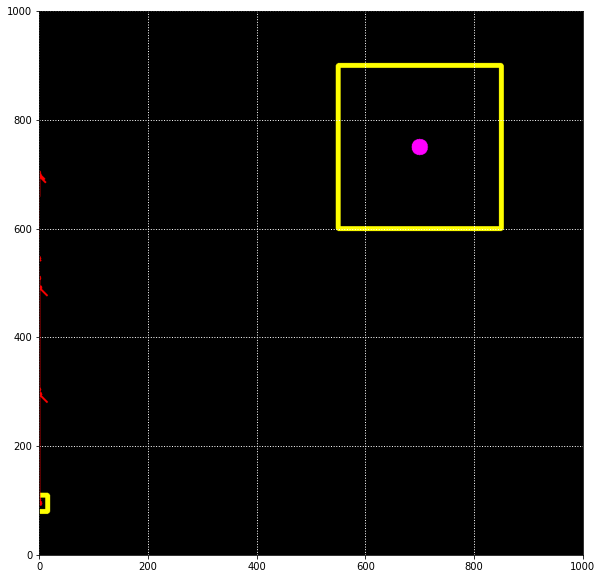

In [10]:
img_area = np.zeros(shape=(1000,1000, 3), dtype=np.int16)
protocol_list = ["lsgo", "sigo", "both"]
text_list = ["なし", "あり"]

#packetの軌跡を描画 
@interact(minHop=(0,19,1), maxHop=(1,21, 1), sourceId=source_list, protocol = protocol_list, text = text_list)
def packetDraw(protocol, sourceId, minHop=0, maxHop = 21, text = "なし"):
    
    img_area = np.zeros(shape=(2100,2100, 3), dtype=np.int16)
    count = 1
    if protocol == 'sigo':
        for log in sigo_df[sigo_df['source_id'] == sourceId].itertuples():
            if count == 1:
                draw_source_area(log, img_area)
                count = count +1
            if log.hopcount >= minHop and log.hopcount <= maxHop:
                draw(log,count,img_area,protocol,text)
        plt.imshow(img_area)
    elif protocol == 'lsgo':
        for log in lsgo_df[lsgo_df['source_id'] == sourceId].itertuples():
            if count == 1:
                draw_source_area(log, img_area)
                count = count +1
            if log.hopcount >= minHop and log.hopcount <= maxHop:
                draw(log,count,img_area,protocol,text)
        plt.imshow(img_area)
    else:
        
        for log in sigo_df[sigo_df['source_id'] == sourceId].itertuples():
            if count == 1:
                draw_source_area(log, img_area)
                count = count +1
            if log.hopcount >= minHop and log.hopcount <= maxHop:
                draw(log,count,img_area,'sigo',text)
        for log in lsgo_df[lsgo_df['source_id'] == sourceId].itertuples():
            if log.hopcount >= minHop and log.hopcount <= maxHop:
                draw(log,count,img_area,'lsgo',text)
        plt.imshow(img_area)

210 344